In [22]:
import os
print("Répertoire courant :", os.getcwd())

Répertoire courant : c:\Users\romai\OneDrive\Tiedostot\Projet COVID\scripts_viz


In [23]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

# Définir les chemins
base_path = "../Dataset/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset"
classes = ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']

# Paramètres
IMG_SIZE = 128

# Fonction de chargement
def load_all_images(base_path, classes, img_size=128):
    images = []
    labels = []
    
    for class_name in classes:
        image_folder = os.path.join(base_path, class_name, 'images')
        if not os.path.exists(image_folder):
            print(f"Dossier manquant pour {class_name}")
            continue
        
        for filename in tqdm(os.listdir(image_folder), desc=f"Chargement {class_name}"):
            if filename.endswith(".png"):
                img_path = os.path.join(image_folder, filename)
                img = Image.open(img_path).convert('L')  # Conversion en niveaux de gris
                img = img.resize((img_size, img_size))
                images.append(np.array(img).flatten())
                labels.append(class_name)
    
    return np.array(images), np.array(labels)

# Lancer le chargement
X, y = load_all_images(base_path, classes, IMG_SIZE)

print(f"Nombre total d'images : {X.shape[0]}")
print(f"Taille d'une image vectorisée : {X.shape[1]}")


Chargement Viral Pneumonia: 100%|██████████| 1345/1345 [00:03<00:00, 378.45it/s]


Nombre total d'images : 21165
Taille d'une image vectorisée : 16384


Shape après PCA : (21165, 50)
Variance expliquée cumulée : 0.89


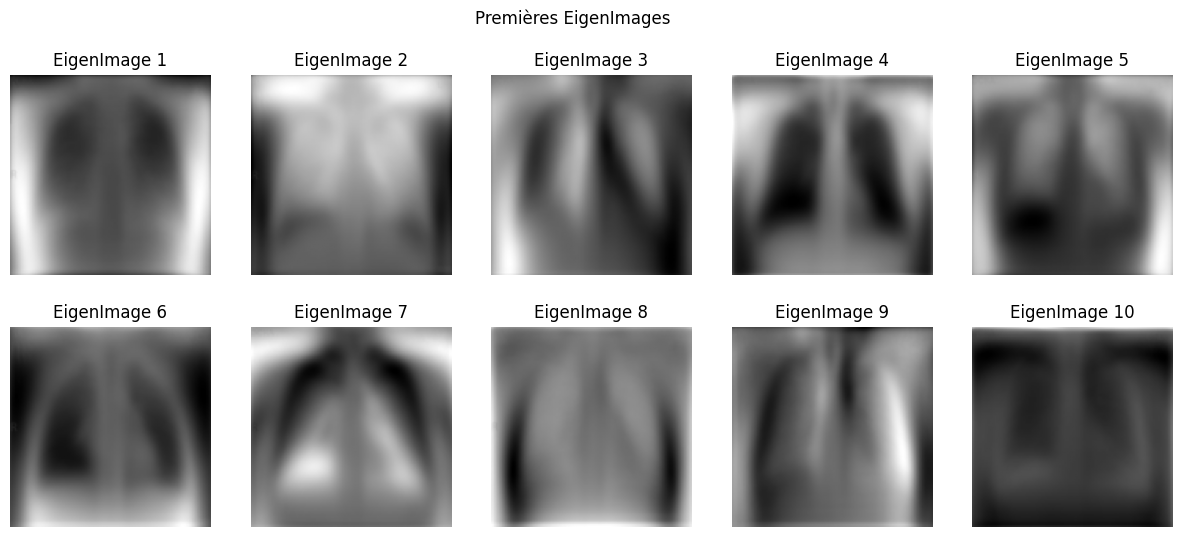

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Normalisation des pixels
X_norm = X / 255.0

# Application de la PCA
n_components = 50  # On garde 50 composantes pour commencer
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_norm)

print(f"Shape après PCA : {X_pca.shape}")
print(f"Variance expliquée cumulée : {np.sum(pca.explained_variance_ratio_):.2f}")

# Visualisation des 10 premières EigenImages
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    eigenimage = pca.components_[i].reshape(IMG_SIZE, IMG_SIZE)
    ax.imshow(eigenimage, cmap='gray')
    ax.set_title(f'EigenImage {i+1}')
    ax.axis('off')
plt.suptitle("Premières EigenImages")
plt.show()

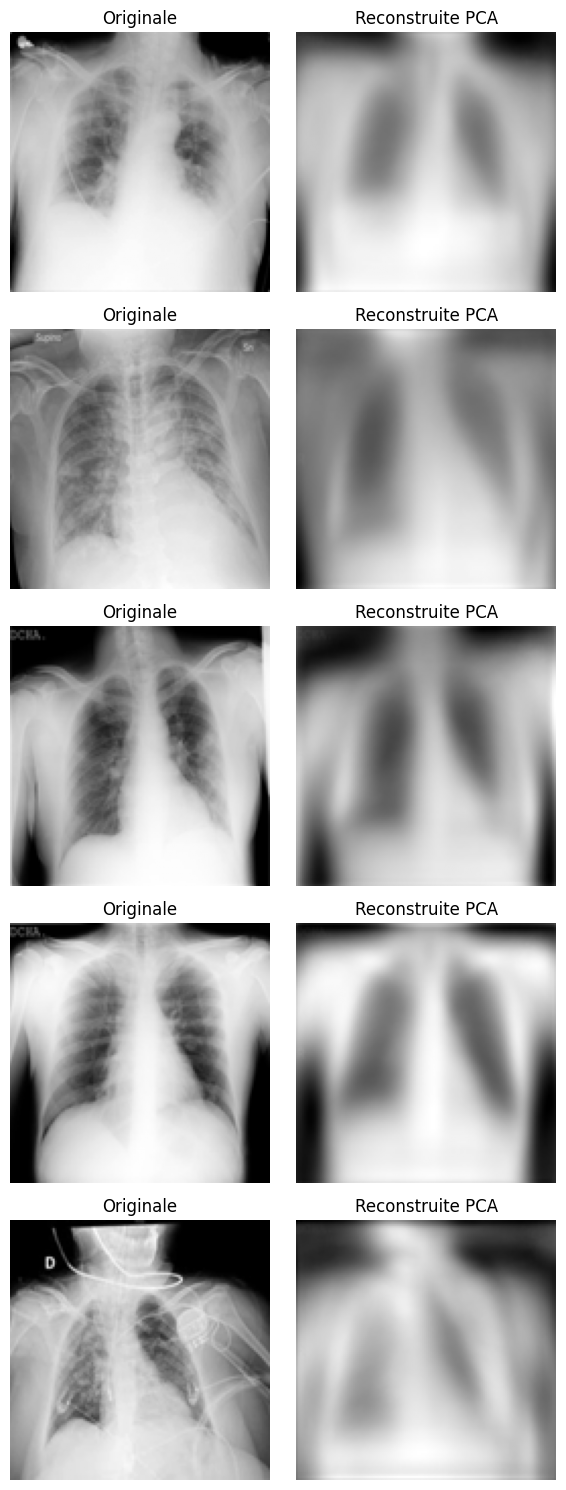

In [5]:
# Sélectionner quelques images à reconstruire (ex: les 5 premières)
n_samples = 5
X_projected = pca.inverse_transform(X_pca[:n_samples])

# Affichage comparaison Original vs Reconstruit
fig, axes = plt.subplots(n_samples, 2, figsize=(6, n_samples * 3))

for i in range(n_samples):
    # Image originale
    axes[i, 0].imshow(X_norm[i].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    axes[i, 0].set_title("Originale")
    axes[i, 0].axis('off')
    
    # Image reconstruite
    axes[i, 1].imshow(X_projected[i].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    axes[i, 1].set_title("Reconstruite PCA")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.6357
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 0.5868
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - loss: 0.5814
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.5777
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - loss: 0.5763
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - loss: 0.5734
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - loss: 0.5716
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - loss: 0.5720
Epoch 9/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 0.5697
Epoch 10/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 0.5690
Epoch 11/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - loss: 0.5689
Epoch 12/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - loss: 0.5676
Epoch 13/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - loss: 0.5669
Epoch 14/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 0.5676
Epoch 15/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 0.5670
Epoc

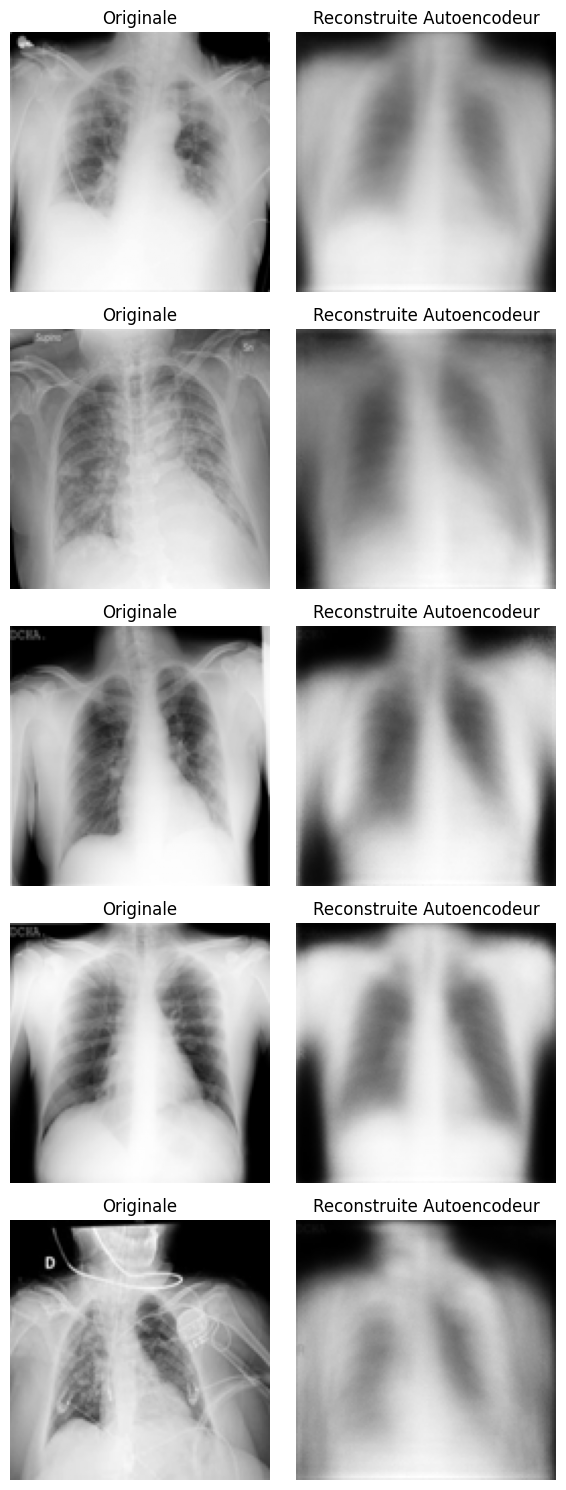

In [6]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Définition de l'Autoencodeur simple
input_dim = IMG_SIZE * IMG_SIZE
encoding_dim = 50  # Pour comparer avec la PCA

input_img = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(encoding_dim, activation='relu')(encoded)

decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Entraînement (rapide pour démonstration)
autoencoder.fit(X_norm, X_norm,
                epochs=20,
                batch_size=256,
                shuffle=True)

# Reconstruction des images
X_decoded = autoencoder.predict(X_norm[:5])

# Affichage comparaison Original vs Reconstruit (Autoencodeur)
fig, axes = plt.subplots(5, 2, figsize=(6, 15))

for i in range(5):
    axes[i, 0].imshow(X_norm[i].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    axes[i, 0].set_title("Originale")
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(X_decoded[i].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    axes[i, 1].set_title("Reconstruite Autoencodeur")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()



In [7]:
from tensorflow.keras.models import Model

# Définir le modèle Encoder (de l'entrée jusqu'au latent space)
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[2].output)

# Appliquer l'encoder sur toutes les images
latent_vectors = encoder.predict(X_norm)

print(f"Shape du latent space : {latent_vectors.shape}")

662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Shape du latent space : (21165, 50)


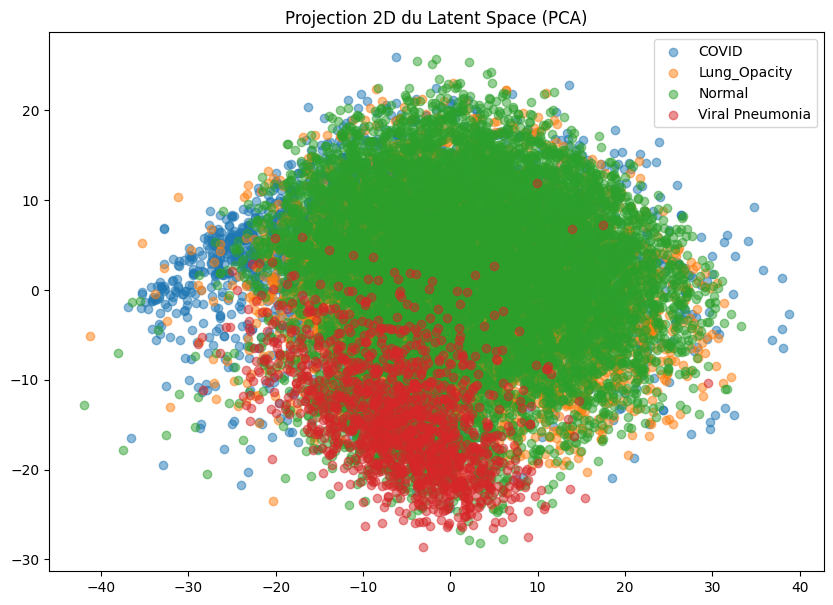

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Réduire à 2D pour visualisation
pca_visu = PCA(n_components=2)
latent_2D = pca_visu.fit_transform(latent_vectors)

# Affichage
plt.figure(figsize=(10,7))
for label in np.unique(y):
    idx = np.where(y == label)
    plt.scatter(latent_2D[idx, 0], latent_2D[idx, 1], label=label, alpha=0.5)

plt.title("Projection 2D du Latent Space (PCA)")
plt.legend()
plt.show()

c:\Users\romai\anaconda3\envs\tpot310\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


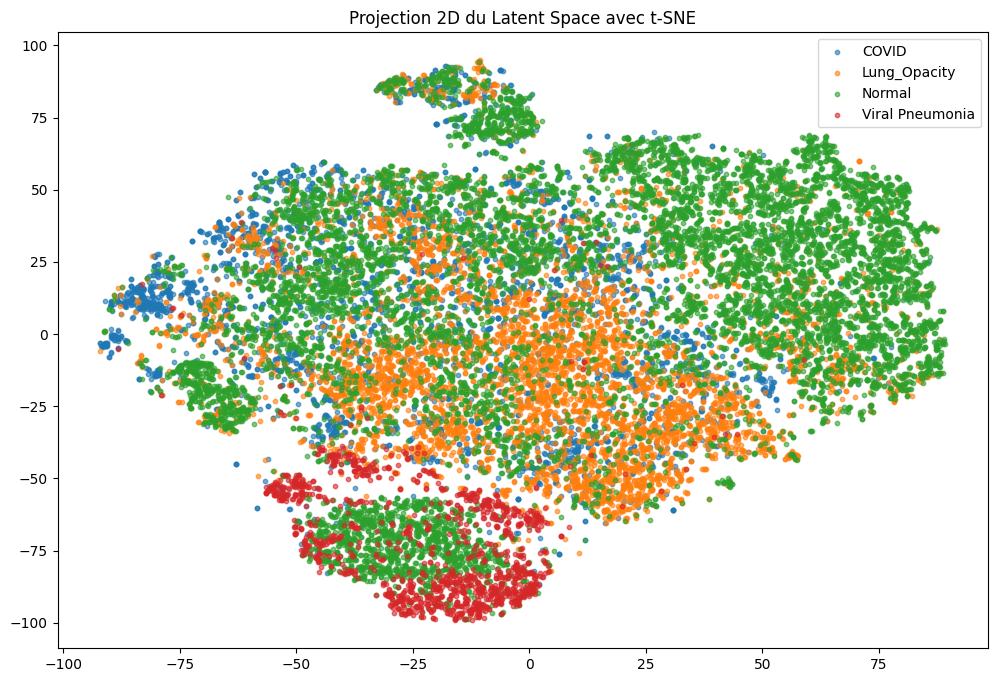

In [9]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Lancement du t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
latent_tsne = tsne.fit_transform(latent_vectors)

# Affichage du résultat
plt.figure(figsize=(12,8))
for label in np.unique(y):
    idx = np.where(y == label)
    plt.scatter(latent_tsne[idx, 0], latent_tsne[idx, 1], label=label, alpha=0.6, s=10)

plt.title("Projection 2D du Latent Space avec t-SNE")
plt.legend()
plt.show()

In [10]:
X_decoded = autoencoder.predict(X_norm, batch_size=256)

from skimage.metrics import structural_similarity as ssim
import numpy as np

# Reshape des datasets pour le calcul
originals = X_norm.reshape((-1, IMG_SIZE, IMG_SIZE))
reconstructions = X_decoded.reshape((-1, IMG_SIZE, IMG_SIZE))

# Calcul du SSIM pour chaque image
ssim_scores = []

print("Calcul du SSIM en cours...")

for i in range(len(originals)):
    score = ssim(originals[i], reconstructions[i], data_range=1.0)
    ssim_scores.append(score)
    
    # Affichage de progression simple
    if i % 2000 == 0:
        print(f"{i} / {len(originals)} images traitées")

# Moyenne globale
mean_ssim = np.mean(ssim_scores)

print(f"\n✅ SSIM moyen sur {len(originals)} images : {mean_ssim:.4f}")


83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Calcul du SSIM en cours...
0 / 21165 images traitées
2000 / 21165 images traitées
4000 / 21165 images traitées
6000 / 21165 images traitées
8000 / 21165 images traitées
10000 / 21165 images traitées
12000 / 21165 images traitées
14000 / 21165 images traitées
16000 / 21165 images traitées
18000 / 21165 images traitées
20000 / 21165 images traitées

✅ SSIM moyen sur 21165 images : 0.6504


### 🧪 Expérimentation : Impact de la Taille du Latent Space (50 vs 100 dimensions)

Dans cette section, nous cherchons à évaluer l'impact d'une augmentation de la taille du **latent space** de l'autoencodeur sur la qualité de reconstruction des radiographies pulmonaires.

#### 🎯 Objectifs :
- Comparer un autoencodeur avec **100 dimensions** dans le latent space à celui précédemment utilisé avec **50 dimensions**.
- Vérifier si l'augmentation du nombre de dimensions améliore significativement la fidélité de la reconstruction, mesurée via le **SSIM (Structural Similarity Index)**.
- Surveiller l'apparition éventuelle de **surapprentissage**, en observant l'évolution de la perte (`loss`) sur l'ensemble d'entraînement et de validation.

#### ⚙️ Protocole :
- Entraînement de l'autoencodeur avec :
  - **Latent space = 100**
  - **20 epochs**
  - Batch size = 256
  - Validation split de 10% pour suivi du surapprentissage.
- Calcul du **SSIM** sur l'intégralité des 21 165 images.
- Analyse des résultats : gain en qualité vs complexité accrue.

> Cette expérimentation permettra de mieux comprendre le compromis entre **compression** et **qualité de restitution**, et d'orienter nos choix architecturaux pour les futures étapes de modélisation.

In [11]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Définition de l'autoencodeur avec latent space = 100
input_dim = IMG_SIZE * IMG_SIZE
encoding_dim = 100  # Nouveau latent space

input_img = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(encoding_dim, activation='relu')(encoded)

decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder_100 = Model(input_img, decoded)
autoencoder_100.compile(optimizer='adam', loss='binary_crossentropy')


In [12]:
history = autoencoder_100.fit(X_norm, X_norm,
                              epochs=20,
                              batch_size=256,
                              shuffle=True,
                              validation_split=0.1)  # On garde 10% pour suivre le surapprentissage


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 0.6372 - val_loss: 0.6021
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.5894 - val_loss: 0.5906
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.5801 - val_loss: 0.5871
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.5767 - val_loss: 0.5852
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.5744 - val_loss: 0.5850
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0.5727 - val_loss: 0.5814
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.5715 - val_loss: 0.5804
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.5697 - val_loss: 0.5793
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 0.5698 - val_loss: 0.5778
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - loss: 0.5676 - val_loss: 0.5769
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 0.5665 - val_loss: 0.5761
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - loss: 0.

In [13]:
# Reconstruction complète
X_decoded_100 = autoencoder_100.predict(X_norm, batch_size=256)

# Calcul du SSIM
from skimage.metrics import structural_similarity as ssim

originals = X_norm.reshape((-1, IMG_SIZE, IMG_SIZE))
reconstructions = X_decoded_100.reshape((-1, IMG_SIZE, IMG_SIZE))

ssim_scores = []
print("Calcul du SSIM (Latent 100) en cours...")

for i in range(len(originals)):
    score = ssim(originals[i], reconstructions[i], data_range=1.0)
    ssim_scores.append(score)
    if i % 2000 == 0:
        print(f"{i} / {len(originals)} images traitées")

mean_ssim_100 = np.mean(ssim_scores)
print(f"✅ SSIM moyen (Latent 100) sur {len(originals)} images : {mean_ssim_100:.4f}")


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
Calcul du SSIM (Latent 100) en cours...
0 / 21165 images traitées
2000 / 21165 images traitées
4000 / 21165 images traitées
6000 / 21165 images traitées
8000 / 21165 images traitées
10000 / 21165 images traitées
12000 / 21165 images traitées
14000 / 21165 images traitées
16000 / 21165 images traitées
18000 / 21165 images traitées
20000 / 21165 images traitées
✅ SSIM moyen (Latent 100) sur 21165 images : 0.6502


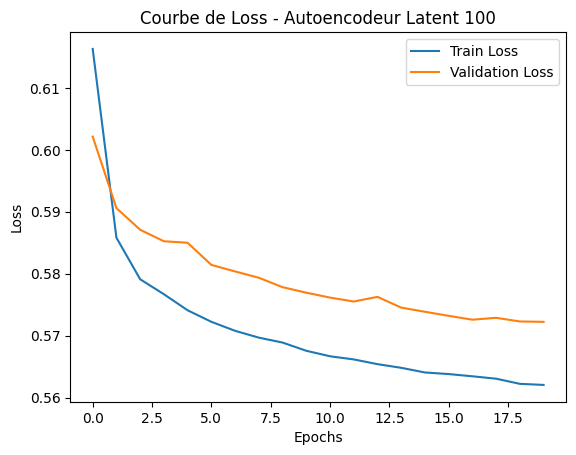

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Courbe de Loss - Autoencodeur Latent 100')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


### 🚀 Passage à l'Autoencodeur Convolutionnel (CAE)

Après avoir expérimenté un autoencodeur dense classique pour la réduction dimensionnelle et la reconstruction des radiographies pulmonaires, nous avons identifié une limite majeure de cette approche : 

➡️ L'**absence de prise en compte de la relation spatiale** entre les pixels, due à l'obligation d'aplatir les images avant traitement.  
Cette limitation impacte la qualité de la reconstruction, notamment sur les détails fins essentiels en imagerie médicale.

#### 🎯 Objectif de cette nouvelle démarche :
Mettre en place un **Autoencodeur Convolutionnel (CAE)** afin de :
- Exploiter pleinement la nature **2D** des images radiographiques.
- Préserver les **structures locales** (contours, textures, motifs pathologiques) grâce aux filtres convolutifs.
- Améliorer la qualité de reconstruction par rapport à l'autoencodeur dense, tout en maintenant une compression efficace.

#### ⚙️ Protocole :
- Architecture simple avec couches de **Convolution**, **Pooling** et **UpSampling**.
- Entraînement sur l'ensemble du dataset avec les mêmes paramètres que l'autoencodeur dense pour garantir une comparaison équitable (**batch_size = 256**, **20 epochs**).
- Évaluation de la performance via :
  - Observation visuelle des images reconstruites.
  - Calcul du **SSIM** pour mesurer la fidélité structurelle.
  - Analyse des courbes de perte (loss) pour vérifier la stabilité de l'apprentissage.

> Cette étape vise à démontrer l'intérêt des architectures convolutionnelles pour des données médicales complexes et à poser les bases d'une approche plus robuste pour la suite du projet.


In [30]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

# Reshape des données pour le CAE
X_cnn = X_norm.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

input_img = Input(shape=(IMG_SIZE, IMG_SIZE, 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder_cnn = Model(input_img, decoded)
autoencoder_cnn.compile(optimizer='adam', loss='binary_crossentropy')


In [16]:
history_cnn = autoencoder_cnn.fit(X_cnn, X_cnn,
                                   epochs=20,
                                   batch_size=256,
                                   shuffle=True,
                                   validation_split=0.1)


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 96s 918ms/step - loss: 0.6203 - val_loss: 0.5628
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 62s 823ms/step - loss: 0.5546 - val_loss: 0.5588
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 60s 804ms/step - loss: 0.5518 - val_loss: 0.5578
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 61s 808ms/step - loss: 0.5501 - val_loss: 0.5572
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 75s 721ms/step - loss: 0.5497 - val_loss: 0.5573
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 60s 793ms/step - loss: 0.5490 - val_loss: 0.5568
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 59s 793ms/step - loss: 0.5494 - val_loss: 0.5564
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 59s 789ms/step - loss: 0.5480 - val_loss: 0.5566
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 59s 791ms/step - loss: 0.5480 - val_loss: 0.5561
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3535s 48s/step - loss: 0.5476 - val_loss: 0.5563
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 55s 726ms/step - loss: 0.5481 - val_loss: 0.5563
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 88

In [31]:
from skimage.metrics import structural_similarity as ssim

originals_cnn = X_cnn.reshape((-1, IMG_SIZE, IMG_SIZE))  # Retirer le canal pour le SSIM
reconstructions_cnn = X_decoded_cnn.reshape((-1, IMG_SIZE, IMG_SIZE))

ssim_scores_cnn = []
print("Calcul du SSIM (CAE) en cours...")

for i in range(len(originals_cnn)):
    score = ssim(originals_cnn[i], reconstructions_cnn[i], data_range=1.0)
    ssim_scores_cnn.append(score)
    if i % 2000 == 0:
        print(f"{i} / {len(originals_cnn)} images traitées")

mean_ssim_cnn = np.mean(ssim_scores_cnn)
print(f"✅ SSIM moyen (CAE) sur {len(originals_cnn)} images : {mean_ssim_cnn:.4f}")


Calcul du SSIM (CAE) en cours...
0 / 21165 images traitées
2000 / 21165 images traitées
4000 / 21165 images traitées
6000 / 21165 images traitées
8000 / 21165 images traitées
10000 / 21165 images traitées
12000 / 21165 images traitées
14000 / 21165 images traitées
16000 / 21165 images traitées
18000 / 21165 images traitées
20000 / 21165 images traitées
✅ SSIM moyen (CAE) sur 21165 images : 0.3664


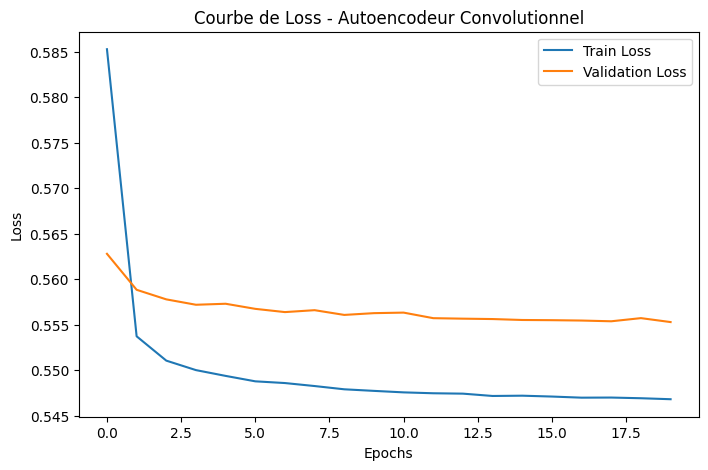

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Courbe de Loss - Autoencodeur Convolutionnel')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


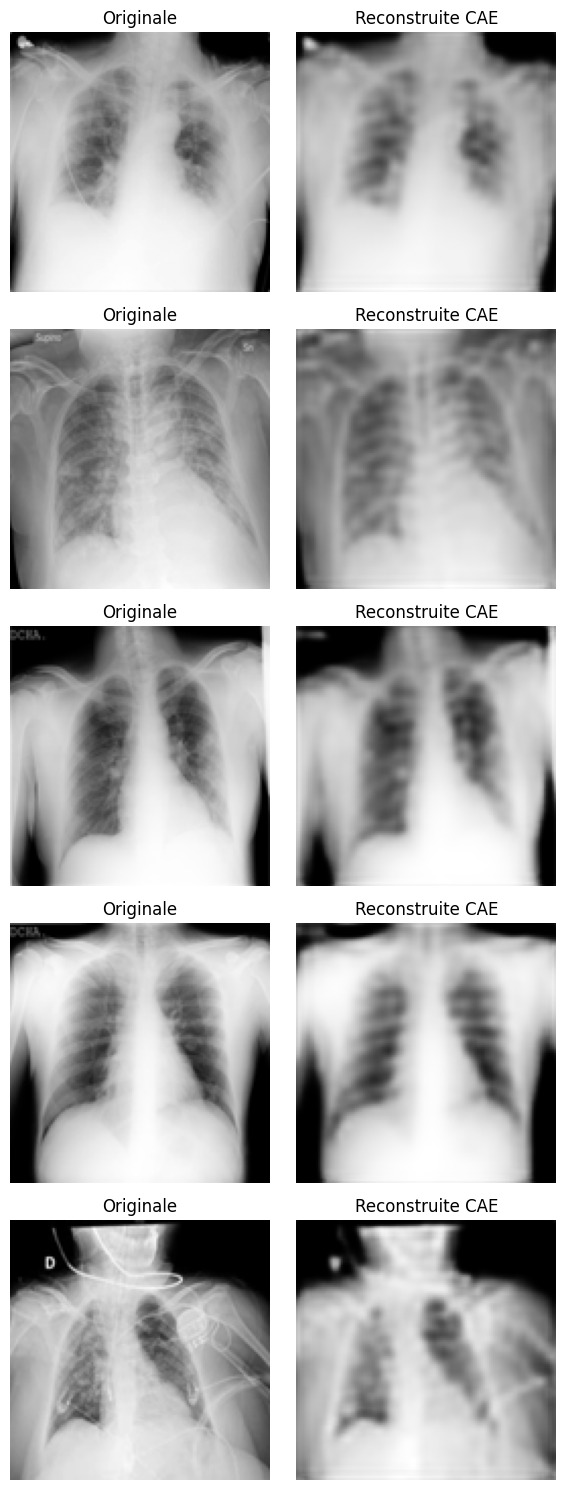

In [20]:
import matplotlib.pyplot as plt

# Sélection de 5 images pour l'affichage
n_samples = 5

fig, axes = plt.subplots(n_samples, 2, figsize=(6, n_samples * 3))

for i in range(n_samples):
    # Image originale
    axes[i, 0].imshow(X_cnn[i].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    axes[i, 0].set_title("Originale")
    axes[i, 0].axis('off')
    
    # Image reconstruite par le CAE
    axes[i, 1].imshow(X_decoded_cnn[i].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    axes[i, 1].set_title("Reconstruite CAE")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


In [32]:
from tensorflow.keras.models import Model

# Création du modèle encoder à partir du CAE
encoder_cnn = Model(inputs=autoencoder_cnn.input, outputs=autoencoder_cnn.layers[4].output)

# Extraction du latent space
latent_cnn = encoder_cnn.predict(X_cnn, batch_size=256)

print(f"Latent CNN shape : {latent_cnn.shape}")


83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step
Latent CNN shape : (21165, 32, 32, 16)


In [35]:
latent_cnn_flat = latent_cnn.reshape(latent_cnn.shape[0], -1)
print(f"Shape aplati : {latent_cnn_flat.shape}")



Shape aplati : (21165, 16384)


In [36]:
tsne_3d = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=42)
latent_cnn_3D = tsne_3d.fit_transform(latent_cnn_flat)


c:\Users\romai\anaconda3\envs\tpot310\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


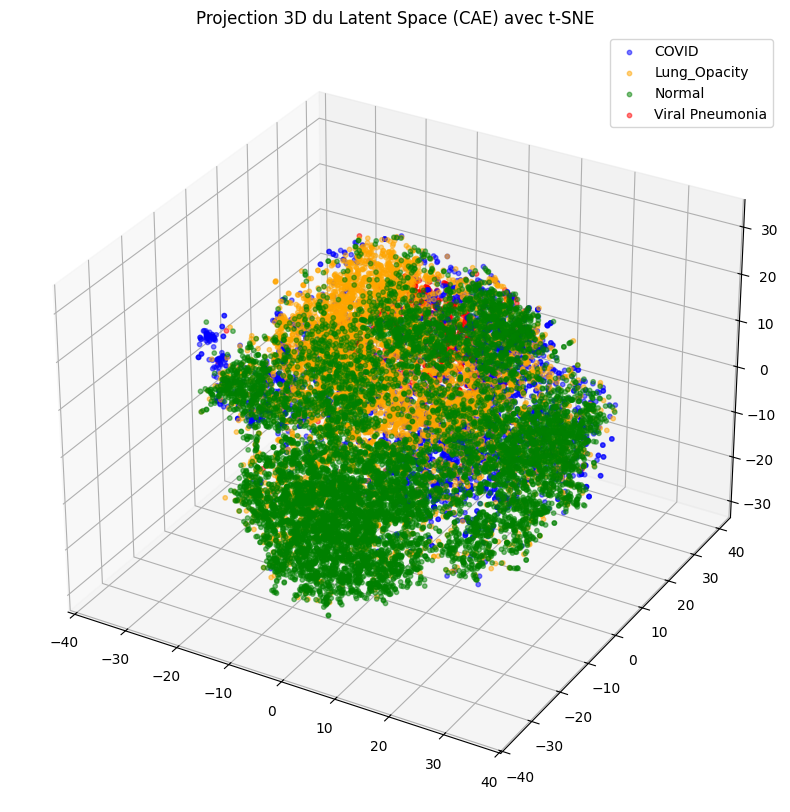

In [37]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Visualisation 3D
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')

colors = {'COVID':'blue', 'Normal':'green', 'Lung_Opacity':'orange', 'Viral Pneumonia':'red'}

for label in np.unique(y):
    idx = np.where(y == label)
    ax.scatter(latent_cnn_3D[idx, 0], latent_cnn_3D[idx, 1], latent_cnn_3D[idx, 2], 
               label=label, alpha=0.5, s=10, c=colors[label])

ax.set_title("Projection 3D du Latent Space (CAE) avec t-SNE")
ax.legend()
plt.show()
